# AI-Driven Equipment Maintenance - Optimization and Scale-up

**Purpose:** To optimize the selected model in the previous sections, using hyperparameter tunning, feature importance and/or other tecniques to ensure this prototype is able to handle a real-world version of the final application.

**Hyperparameter Tuning:** is the AI&ML process of optimizing the settings that govern how a model learns. Unlike model parameters, which are learned during training, hyperparameters are predefined before training begins and directly impact the performance of the model.

**Feature Importance:** tells us which input variables (features) have the biggest impact on a machine learning model's predictions.

**Class Imbalance:** happens when one class in your dataset has many more samples than another.

Install and import H2O

In [1]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 5.2 MB/s eta 0:00:00


In [2]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
from google.colab import drive
import pandas as pd
from ipywidgets import widgets
from IPython.display import display

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpus31nna8
  JVM stdout: /tmp/tmpus31nna8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpus31nna8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_unknownUser_e7180m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Load and prepare data

In [3]:
df = h2o.import_file("00-AI4I 2020 Predictive Maintenance Dataset.csv")

# Drop irrelevant columns
df = df.drop(["\ufeffUDI", "Product ID", "Type"], axis=1)

# Convert categorical variables
#df["Type"] = df["Type"].asfactor()
df["Failure Type"] = df["Failure Type"].asfactor()
df["Target"] = df["Target"].asfactor()

# Split dataset
train, test = df.split_frame(ratios=[0.75], seed=42)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Run AutoML for failure occurence (Target)

In [4]:
# Drop 'Failure Type' (to prevent leakage)
X_occurrence = train.drop(["Target", "Failure Type"])
y_occurrence = train["Target"]

# Run H2O AutoML
aml_occ = H2OAutoML(max_models=20, balance_classes=True, stopping_metric="AUC", seed=42)
aml_occ.train(x=X_occurrence.columns, y="Target", training_frame=train)

# View leaderboard
aml_occ.leaderboard

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20250506_53126,0.987906,0.0424572,0.822815,0.135202,0.105769,0.0111871
StackedEnsemble_BestOfFamily_1_AutoML_1_20250506_53126,0.986418,0.0450413,0.80447,0.133919,0.110091,0.01212
XGBoost_grid_1_AutoML_1_20250506_53126_model_2,0.985988,0.0462382,0.785033,0.118419,0.112034,0.0125515
XGBoost_3_AutoML_1_20250506_53126,0.984951,0.0712854,0.766294,0.132843,0.143178,0.0204998
XGBoost_2_AutoML_1_20250506_53126,0.9839,0.062334,0.787457,0.12461,0.132142,0.0174615
GBM_1_AutoML_1_20250506_53126,0.983443,0.0689261,0.775861,0.132429,0.145637,0.0212101
XGBoost_1_AutoML_1_20250506_53126,0.983407,0.0873451,0.751769,0.170447,0.163283,0.0266614
GBM_grid_1_AutoML_1_20250506_53126_model_1,0.982324,0.0701192,0.746618,0.191587,0.140739,0.0198075
GBM_2_AutoML_1_20250506_53126,0.980072,0.0728148,0.769832,0.16609,0.143121,0.0204836
GBM_3_AutoML_1_20250506_53126,0.978707,0.0729057,0.774154,0.13236,0.144179,0.0207876


Print the leader model summary and performance metrics for failure occurence

In [5]:
# Get the best model from AutoML
best_model = aml_occ.leader

# Print model performance
best_model.model_performance().show()

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0019423410732739622
RMSE: 0.044071998743805144
LogLoss: 0.010913090181043425
AUC: 0.9999437636724572
AUCPR: 0.9983144546813604
Gini: 0.9998875273449144
Null degrees of freedom: 7502
Residual degrees of freedom: 7493
Null deviance: 2158.5933432232355
Residual deviance: 163.7618312567376
AIC: 183.7618312567376

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5959837465460464
       0     1    Error    Rate
-----  ----  ---  -------  ------------
0      7252  6    0.0008   (6.0/7258.0)
1      2     243  0.0082   (2.0/245.0)
Total  7254  249  0.0011   (8.0/7503.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.595984     0.983806  135
max f2                       0.534405     0.991903  141
max f0point5                 0.631557     0.980472  132
max accuracy                 0.595984     0.998934  135
max precision                0.998104     1         0
max recall                   0.534405     1         141
max specificity              0.998104     1         0
max absolute_mcc             0.595984     0.983289  135
max min_per_class_accuracy   0.534405     0.998622  141
max mean_per_class_accuracy  0.534405     0.999311  141
max tns                      0.998104     7258      0
max fns                      0.998104     244       0
max fps                      0.000201096  7258      399
max tps                      0.534405     245       141
max tnr                      0.998104     1         0
max fnr                      0.998104     0.995918  0
max fpr                      0.000201096  1         399
max tpr                      0.534405     1         141

Gains/Lift Table: Avg response rate:  3.27 %, avg score:  3.73 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0101293                   0.970198           30.6245  30.6245            1                0.984242     1                           0.984242            0.310204        0.310204                   2962.45  2962.45            0.310204
2        0.0201253                   0.942387           30.6245  30.6245            1                0.95901      1                           0.97171             0.306122        0.616327                   2962.45  2962.45            0.616327
3        0.0301213                   0.824343           30.2162  30.489             0.986667         0.90294      0.995575                    0.948888            0.302041        0.918367                   2921.62  2948.9             0.91823
4        0.0401173                   0.173558           8.16653  24.9269            0.266667         0.44943      0.813953                    0.824438            0.0816327       1                          716.653  2392.69            0.992284
5        0.0501133                   0.0906093          0        19.9548            0                0.126371     0.651596                    0.685196            0               1                          -100     1895.48            0.981951
6        0.100093                    0.0132279          0        9.99068            0                0.0376287    0.326232                    0.361844            0               1                          -100     899.068            0.930284
7        0.150073                    0.00367395         0        6.66341            0                0.00717939   0.217584                    0.24372

In [6]:
# Generate predictions on the test set
pred_occurrence = aml_occ.leader.predict(test)

# Convert predictions to a Pandas dataframe for easier analysis
pred_occurrence_df = pred_occurrence.as_data_frame()
test_df = test.as_data_frame()

# Merge predictions with actual values
results_occ = test_df[["Target"]].copy()
results_occ["Predicted_Target"] = pred_occurrence_df["predict"]
print(results_occ.head(10))

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
   Target  Predicted_Target
0       0                 0
1       0                 0
2       0                 0
3       0                 0
4       0                 0
5       0                 0
6       0                 0
7       0                 0
8       0                 0
9       0                 0


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Run AutoML for failure type (Failure Type)

In [7]:
# Keep only failure cases
failure_subset = train[train["Target"] == "1"]

# Drop 'Target' (to prevent leakage)
X_failure = failure_subset.drop(["Target", "Failure Type"])
y_failure = failure_subset["Failure Type"]

# Run H2O AutoML
aml_fail = H2OAutoML(max_models=20, seed=42)
aml_fail.train(x=X_failure.columns, y="Failure Type", training_frame=failure_subset)

# View leaderboard
aml_fail.leaderboard

AutoML progress: |██
05:44:31.760: GBM_1_AutoML_2_20250506_54426 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_2_20250506_54426.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 196.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 196.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 196.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 196.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 196.0.


███████████████████████████████████████

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_1_AutoML_2_20250506_54426,0.0357872,0.168305,0.224454,0.0503796
GBM_2_AutoML_2_20250506_54426,0.0515294,0.241144,0.257714,0.0664166
StackedEnsemble_BestOfFamily_1_AutoML_2_20250506_54426,0.0541241,0.193445,0.243132,0.0591134
GBM_4_AutoML_2_20250506_54426,0.0576404,0.244813,0.263276,0.0693142
XRT_1_AutoML_2_20250506_54426,0.0585827,0.243198,0.27206,0.0740166
XGBoost_grid_1_AutoML_2_20250506_54426_model_2,0.0627646,0.266805,0.278304,0.0774529
GBM_5_AutoML_2_20250506_54426,0.0666088,0.283424,0.280172,0.0784965
GBM_3_AutoML_2_20250506_54426,0.0670401,0.265273,0.274758,0.075492
XGBoost_grid_1_AutoML_2_20250506_54426_model_4,0.0685172,0.342997,0.316984,0.100479
DeepLearning_grid_1_AutoML_2_20250506_54426_model_1,0.068658,0.242191,0.264345,0.0698783


Print the leader model summary and performance metrics for failure type

In [8]:
# Get the best model from AutoML
best_model = aml_fail.leader

# Print detailed model performance
best_model.model_performance().show()

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.001153875187609922
RMSE: 0.03396873838708058
LogLoss: 0.015120531252267842
Null degrees of freedom: 244
Residual degrees of freedom: 208
Null deviance: 651.0960966814969
Residual deviance: 7.409060313611242
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Heat Dissipation Failure    No Failure    Overstrain Failure    Power Failure    Random Failures    Tool Wear Failure    Error    Rate
--------------------------  ------------  --------------------  ---------------  -----------------  -------------------  -------  -------
84                          0             0                     0                0                  0                    0        0 / 84
0                           0             0                     0                0                  0                    nan      0 / 0
0                           0             62                    0                0                  0                    0        0 / 62
0                           0             0                     69               0                  0                    0        0 / 69
0                           0             0                     0                0                  0                    nan      0 / 0
0                           0             0                     0                0                  30                   0        0 / 30
84                          0             62                    69               0                  30                   0        0 / 245

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1
4    1
5    1
6    1

In [9]:
# Filter test data where failure occurred (Target = 1)
failure_test_subset = test[test["Target"] == "1"]

# Generate predictions for failure type classification
pred_failure_type = aml_fail.leader.predict(failure_test_subset)

# Convert predictions to a Pandas dataframe
pred_failure_df = pred_failure_type.as_data_frame()
failure_test_df = failure_test_subset.as_data_frame()

# Merge predictions with actual failure types
results_failure = failure_test_df[["Failure Type"]].copy()
results_failure["Predicted_Failure_Type"] = pred_failure_df["predict"]
print(results_failure.head(10))

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
         Failure Type Predicted_Failure_Type
0       Power Failure          Power Failure
1       Power Failure          Power Failure
2       Power Failure          Power Failure
3  Overstrain Failure     Overstrain Failure
4  Overstrain Failure     Overstrain Failure
5  Overstrain Failure     Overstrain Failure
6       Power Failure          Power Failure
7   Tool Wear Failure      Tool Wear Failure
8       Power Failure          Power Failure
9  Overstrain Failure     Overstrain Failure


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Class Imbalance

In [10]:
print(train["Target"].table())
print(failure_subset["Failure Type"].table())

  Target    Count
       0     7258
       1      245
[2 rows x 2 columns]

Failure Type                Count
Heat Dissipation Failure       84
Overstrain Failure             62
Power Failure                  69
Tool Wear Failure              30
[4 rows x 2 columns]



Class imbalance is present in dataset, we will set balance_classes=True and re-train the model to assess results.

Feature Importance:

Since feature importance extraction is not directly available for a stacked ensemble model, we will use metalearner to identify which base model contributes the most, to then assess feature importance.

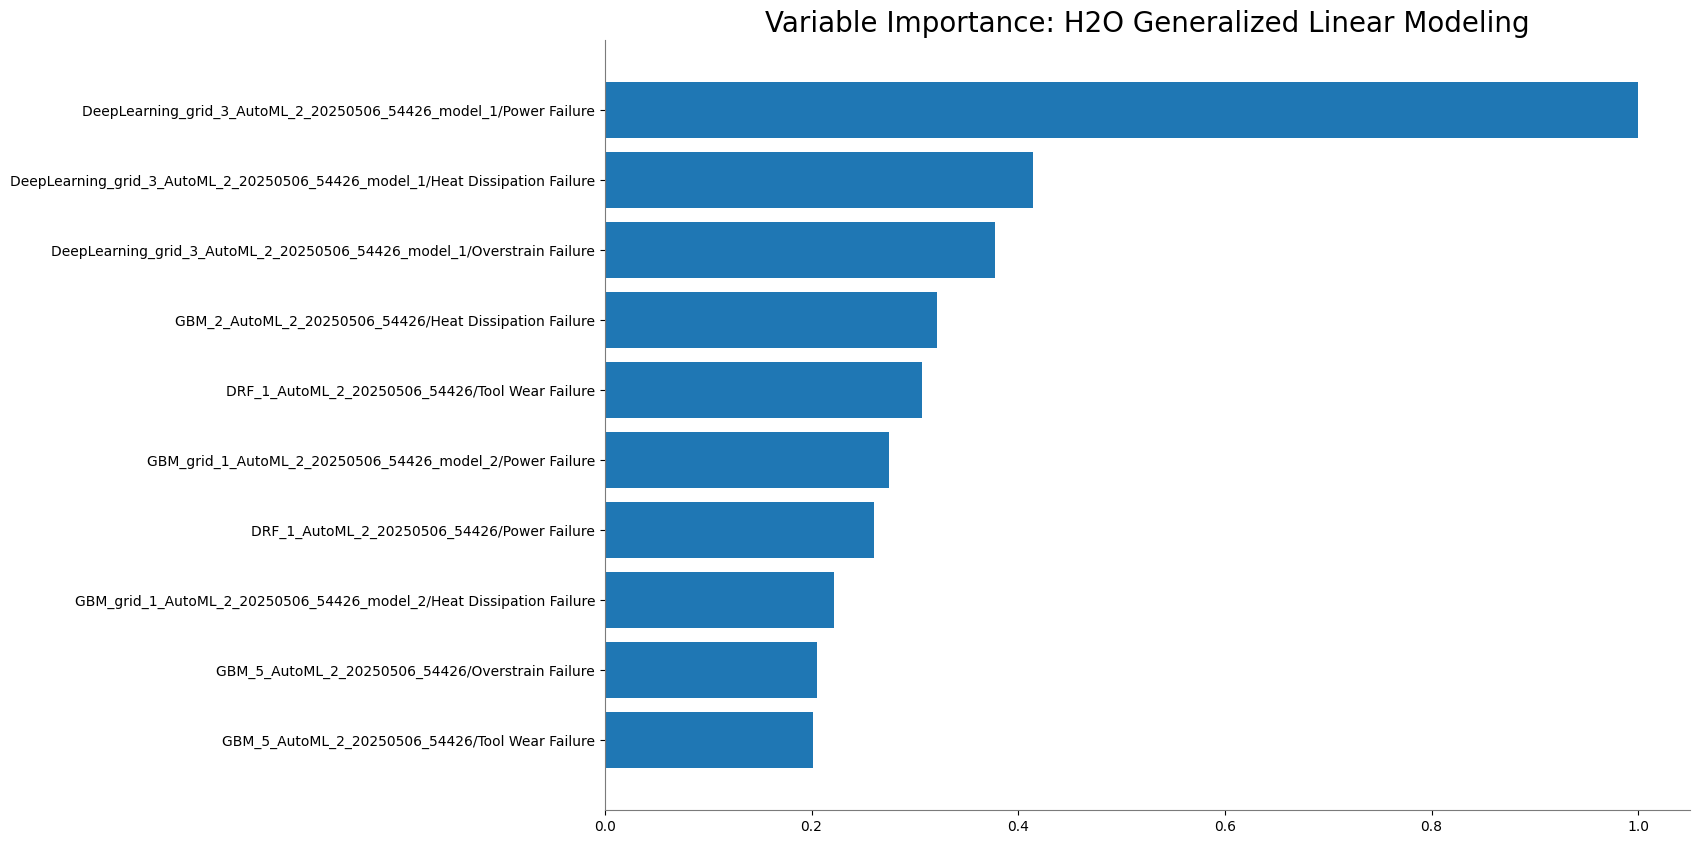

                  variable  relative_importance  scaled_importance  percentage
0              Torque [Nm]           278.279694           1.000000    0.391492
1          Tool wear [min]           150.892807           0.542234    0.212280
2   Rotational speed [rpm]           135.165329           0.485718    0.190154
3      Air temperature [K]           115.901131           0.416492    0.163053
4  Process temperature [K]            30.579586           0.109888    0.043020


<Figure size 640x480 with 0 Axes>

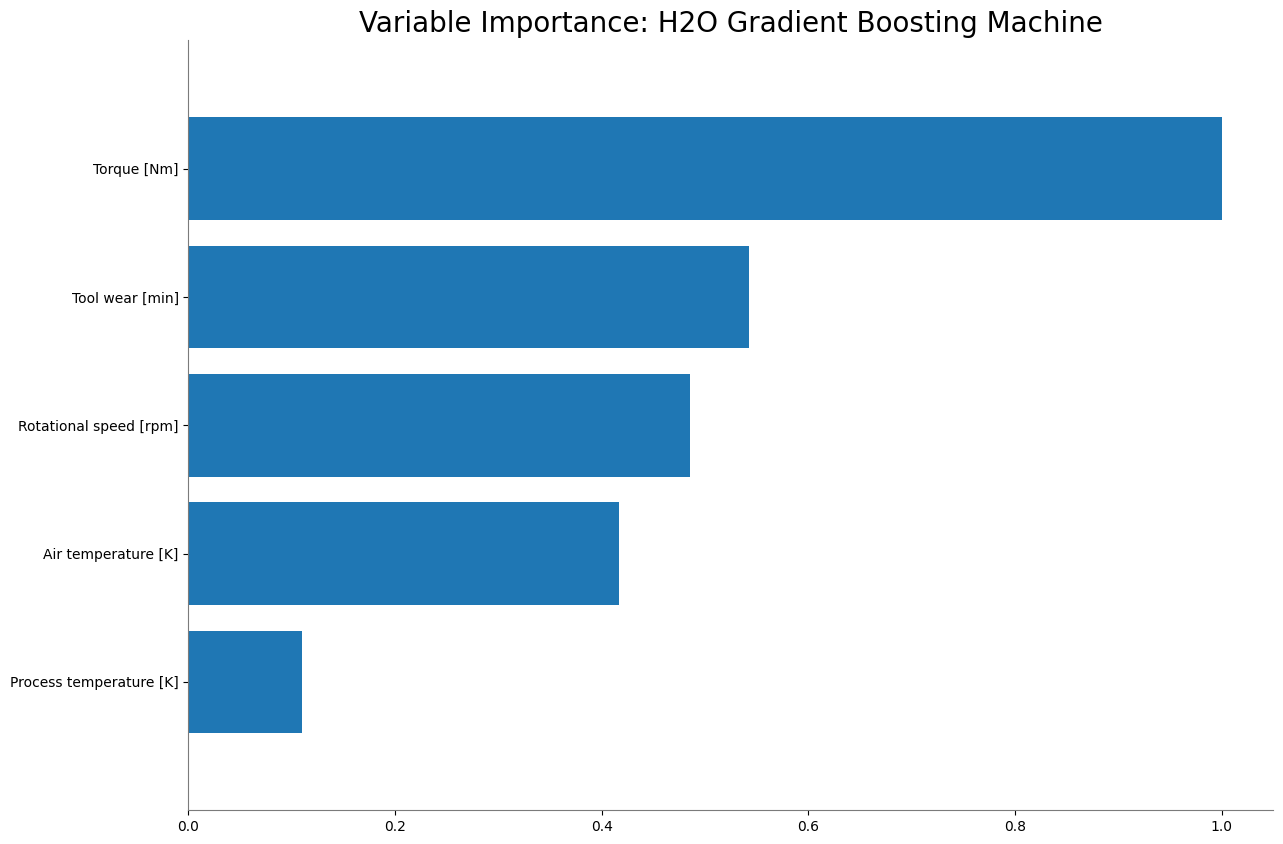

<Figure size 640x480 with 0 Axes>

In [11]:
metalearner = best_model.metalearner() # Get the metalearner object using metalearner() method
metalearner.varimp_plot() # Call varimp_plot on the metalearner object

# Instead of calling best_model.base_models(), directly access the list of base models
base_models = best_model.base_models  # Access the base_models attribute

# Access a specific base model (e.g., the first one):
# Get the model ID of the first base model
gbm_model_id = base_models[0]

# Get the actual model object using h2o.get_model()
gbm_model = h2o.get_model(gbm_model_id)

importance_df = gbm_model.varimp(use_pandas=True)  # Converts to Pandas DataFrame
print(importance_df)

# Get variable importance from the base model:
gbm_model.varimp_plot()

# Results:

Pre-tuning (Occurence):
```
MSE: 0.0017663739548316906
RMSE: 0.042028251865045385
LogLoss: 0.010393370383477983
AUC: 0.9999789113771714
AUCPR: 0.9993890100773136
Gini: 0.9999578227543429
Null degrees of freedom: 7502
Residual degrees of freedom: 7499
Null deviance: 2158.5933432232355
Residual deviance: 155.96291597447066
AIC: 163.96291597447066

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36372043653410735
0	   7253.0	  5.0	 0.0007	 (5.0/7258.0)
1	   1.0	    244.0	0.0041	 (1.0/245.0)

```

Pre-tuning (Failure Type):
```
MSE: 0.002144663761256737
RMSE: 0.04631051458639536
LogLoss: 0.019254489178613925
Mean Per-Class Error: 0.0
```
Proposed changes to model for optimization:

Hyperparameter Tuning: Remove max_runtime_secs to allow indefinite time for deeper optimization, and change stopping_metric="AUC" to prioritize classification performance for imbalanced data.

Class Imbalance: Set balance_classes = True

Feature Importance: Drop Type to avoid unnecesary noise.

The Filure Type model works well, no need to further optimize.

Post-tuning (Occurence):

```
MSE: 0.0024561045663572508
RMSE: 0.04955910175091202
LogLoss: 0.01235501815242331
AUC: 0.9998481619156342
AUCPR: 0.9954264596905618
Gini: 0.9996963238312684
Null degrees of freedom: 7502
Residual degrees of freedom: 7492
Null deviance: 2158.5933432232355
Residual deviance: 185.39940239526413
AIC: 207.39940239526413

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48968290312358936
0	7244.0	  14.0	 0.0019	(14.0/7258.0)
1	 2.0	    243.0	0.0082	(2.0/245.0)
```

Final Selection: For the project, the model selection for the failure occurence is the one tuned because the model has significantly high result parameters while dealing with class imbalance. In addition, the feature importance of the tuned model aligns with real-life values when it comes to motor parameters and maintenance.


Save models for solution use

In [12]:
# Ensure models are correctly assigned
model_occ = aml_occ.leader
model_fail = aml_fail.leader

# Save MOJO models
model_path_occ = model_occ.save_mojo(path="failure_occurrence_model.zip", force=True)
model_path_fail = model_fail.save_mojo(path="failure_type_model.zip", force=True)

# Mount Google Drive for saving
drive.mount('/content/drive')

# Define Drive paths
model_drive_path_occ = "/content/drive/MyDrive/failure_occurrence_model.zip"
model_drive_path_fail = "/content/drive/MyDrive/failure_type_model.zip"

# Save models in Drive
model_occ.save_mojo(path=model_drive_path_occ, force=True)
model_fail.save_mojo(path=model_drive_path_fail, force=True)

# Print confirmation
print(f"Occurrence model saved at: {model_drive_path_occ}")
print(f"Failure type model saved at: {model_drive_path_fail}")

Mounted at /content/drive
Occurrence model saved at: /content/drive/MyDrive/failure_occurrence_model.zip
Failure type model saved at: /content/drive/MyDrive/failure_type_model.zip


#Predicting occurence and failure type

Load models

In [15]:
# Define the paths based on the uploaded files
model_occ_path = "/content/drive/MyDrive/failure_occurrence_model.zip"
model_fail_path = "/content/drive/MyDrive/failure_type_model.zip"

# Load models from local Colab storage
model_occ = h2o.import_mojo(model_occ_path)
model_fail = h2o.import_mojo(model_fail_path)

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Drop down menu for type selection

In [92]:
# Create dropdown widget
size_dropdown = widgets.Dropdown(options=['Select motor type', 'H', 'L', 'M'], value='Select motor type', description='Type:')

# Display dropdown
display(size_dropdown)

# User selection
def on_change(change):
    global selected_size
    selected_size = change.new
    size_dropdown.disabled = True
    print(f"Selected type: {selected_size}")

size_dropdown.observe(on_change, names='value')

Dropdown(description='Type:', options=('Select motor type', 'H', 'L', 'M'), value='Select motor type')

Selected type: M


Parameters input

In [93]:
# Initialize empty input list
input_values = []

# Sequential user input prompts
print("Enter current motor parameters\n")
input_values.append(float(input("Torque [Nm]: ")))
input_values.append(float(input("Air Temperature [K]: ")))
input_values.append(float(input("Process Temperature [K]: ")))
input_values.append(float(input("Rotational Speed [rpm]: ")))
input_values.append(float(input("Tool Wear [min]: ")))

Enter current motor parameters

Torque [Nm]: 19.8
Air Temperature [K]: 300.7
Process Temperature [K]: 309.6
Rotational Speed [rpm]: 1996
Tool Wear [min]: 203


Creating a dataframe of input parameters to use for predictions. User_df dataframe contains the motor parameters, entered by the user, to be predicted. In a real-life scenario, the model would use sensor (or historized) values in a time-series to predict failure occurence and failure type.

In [94]:
# Define feature names (including dropdown selection)
feature_names = ["Torque [Nm]", "Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Tool wear [min]"]


# Create a Pandas DataFrame with user input
user_df = pd.DataFrame([input_values], columns=feature_names)

# Convert to H2OFrame for model predictions
user_h2o = h2o.H2OFrame(user_df)

user_df.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,Torque [Nm],Air temperature [K],Process temperature [K],Rotational speed [rpm],Tool wear [min]
0,19.8,300.7,309.6,1996.0,203.0


In [95]:
pred_occ = model_occ.predict(user_h2o)
failure_occurrence = pred_occ.as_data_frame()["predict"][0]

if failure_occurrence == 0:
    occurence_outcome = "No failure predicted"
else:
    occurence_outcome = "Failure detected"

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [96]:
if failure_occurrence == 1:
    pred_fail_type = model_fail.predict(user_h2o)
    df_fail = pred_fail_type.as_data_frame()
    df_fail_sorted = df_fail.iloc[:, 1:].T.sort_values(by=0, ascending=False)
    failure_type_outcome_1 = df_fail_sorted.index[0]
    failure_type_outcome_2 = df_fail_sorted.index[1]

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [97]:
if failure_occurrence == 1:
  print("Motor shows signs of failure, possible causes are: " + failure_type_outcome_1 + ' or ' + failure_type_outcome_2)
else:
  print(occurence_outcome)

Motor shows signs of failure, possible causes are: Tool Wear Failure or Overstrain Failure


**Final model prediction:**

5 set of parameters were randomly selected and manually entered as inputs to predict failure occurence and type using model.

Below results:

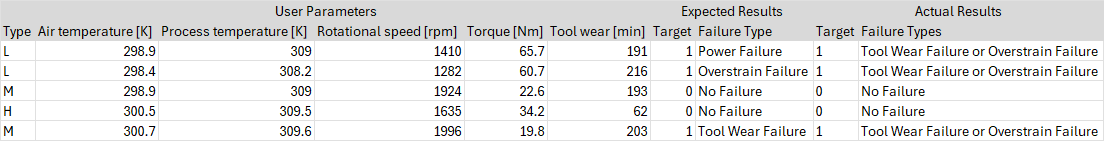


